# FFT tutorial using numpy (and a bit more on plotting)
* FFT is a linear transform of the data from the time domain to the frequency domain. You can move back and forth without losing any information
* FFT allows you to understand how much activity (power or amplitude) in different frequency bands is in your data - very useful especially for cyclical data like cortical oscillations
* Can think about this (a bit loosely) as computing the correlation or dot product between the time domain signal and a series of sinusoids at different frequencies and different phases  

[scipy doc](https://docs.scipy.org/doc/numpy/reference/routines.fft.html)

![nice figure of concept](http://www.spektrumanalizoru.com/images/time_vs_freq1.gif)

![nice animation](https://upload.wikimedia.org/wikipedia/commons/7/72/Fourier_transform_time_and_frequency_domains_%28small%29.gif)

![polar coordinate interpretation](http://www.secretmango.com/jimb/Whitepapers/fft/notation_2.gif)


[website with nice geometric interpretation of dot product](https://jackschaedler.github.io/circles-sines-signals/dotproduct.html)


Equation for dot product: 
$\sum_{n=0}^{N-1} a[n] \cdot b[n]$

In [5]:
# general libs we'll use
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## Generate a signal 
* Generating your own signal is usually the best way to start testing an analysis pipeline because you know the ground truth

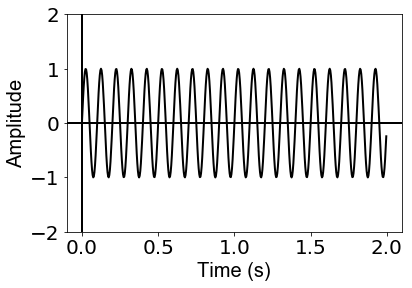

In [49]:
sr = 256                        # samp rate in Hz
f = 10                          # frequency of signal 
tmax = 2                        # duration of signal, in seconds
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# make a sin wave - amp is 1
sw = np.sin(2*pi*f*t)

plt.plot(t, sw, 'k-', linewidth = 2)    # specify x,y data...in this case time and amplitude of sin

# put some labels on the axes - the ** before fig_font is a prefix operator and means "pass all params in fig_font to plt" 
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)

# set the tick marks
plt.xticks(np.arange(0,tmax+.5,.5), color='k', size=20)
plt.yticks((-2,-1,0,1,2), color='k', size=20)

# add some nice vertical/horizontal lines to our figure
plt.axvline(0, color = 'k', linewidth = 2)
plt.axhline(0, color = 'k', linewidth = 2)

# show it
plt.show()

## Do the fft

In [50]:
# use the numpy fft function 
sp = np.fft.rfft(sw)      # rfft = fft for real valued inputs
sp.shape

(257,)

### note that sp is 1/2 the size of the input signal (257 vs 512). If you used 'fft' instead of 'rfft' you would get back a 512 length output, where the first half contains information about positive frequencies and the 2nd half contains info about the negative frequencies. This will seem weird, but for real valued signals, information about the positive and negative frequencies is symetric so we only have to deal with the postive values, which is what "rfft" does automatically for us. If your input data is complex, then you have to deal with both positive and negative frequencies and that is a bit more complex...fortunately this will rarely (if ever) come up for any of you.

## See what the fft returns

In [51]:
# print an element - complex number with real and imaginary parts. 
print(sp[2]) 

(1.2738898619629422e-14-3.9885094375754446e-15j)


## Now calculate the amplitude of the signal at all frequencies. Use np.absolute (np.abs)
* For complex input, a + ib, abs returns sqrt( a^2 + b^2 ), or the **distance from the origin** (amplitude!)
* **this is not the absolute value!**
* need to normalize this number, as the dot product increases with increasing signal length bceause you have more points to multiply and sum (remember definition given above in markdown cell...)

In [52]:
# remember our coordinate system that we talked about earlier...this is the distance from the origin
amp = np.abs(sp)  

# normalize by the number of data points, 
# times 2 cause we're ditching the negative frequencies when we deal with real numbers
amp = (amp  / len(sw) ) * 2   

# note that power, which you sometimes see reported, is amp**2
# pwr = amp**2

In [53]:
# figure out the frequency resolution of the data 

# frequency resolution is dependent on how long your signal is...
freq_steps = 1/tmax

# of call this built in function. 
# Sample spacing is 2nd arg, inverse of the sampling rate. Defaults to 1 and need to be careful!!!
freq = np.fft.rfftfreq(sw.size, dt)   

print('Freq steps computed by hand: ', freq_steps, ' And computed using built-in: ', freq[1]-freq[0])

Freq steps computed by hand:  0.5  And computed using built-in:  0.5


[reference page for figure legends](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html)

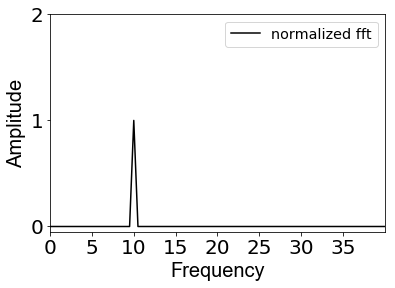

In [54]:
# plot the results!
plt.plot(freq, amp, 'k')            # plot amplitude 

# put a legend on it...
plt.legend(['normalized fft'], loc='best', fontsize='x-large')  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(freq[0:80:10], color='k', size=20)
plt.yticks((0,1,2), color='k', size=20)

# set the axis limits
plt.xlim([0, 40])

# show it
plt.show()

## All good - now we have a representation of the data in the frequency domain. To emphasize that this is just a transform of the data, we can invert the process and go back to our original signal without losing anything (within machine precision at least)

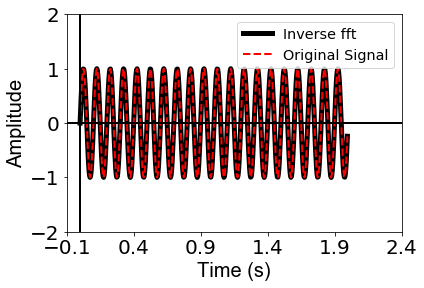

In [55]:
# use the numpy ifft function, inverse FFT
# takes the output from rfft and goes back to the time domain
isp = np.fft.irfft(sp)         

# plot the inverse of the fft
plt.plot(t, isp, 'k-', linewidth = 5)    # specify x,y data...in this case time and amplitude of sin

# then plot a dashed line showing the original signal - should be identical
plt.plot(t, sw, 'r--', linewidth = 2)    # specify x,y data...in this case time and amplitude of sin

plt.legend(['Inverse fft', 'Original Signal'], loc='best', fontsize='x-large')  

# put some labels on the axes
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)

# set the tick marks
plt.xticks(np.arange(-.1,tmax+.5,.5), color='k', size=20)
plt.yticks((-2,-1,0,1,2), color='k', size=20)

# add some nice vertical/horizontal lines 
plt.axvline(0, color = 'k', linewidth = 2)
plt.axhline(0, color = 'k', linewidth = 2)

# show it
plt.show()

## Create a more complex signal that is a mixture of multiple sines at different frequencies...
* can also add some noise to see what happens.

In [60]:
# make a new signal to FFT...combo of sin waves
sr = 1024                       # samp rate in Hz
f = np.array([10,20,30])        # base frequencies in signal 
amp = np.array([.7,.3,.5])
tmax = 2                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# amplitude of the additive noise in our data.
noise_amp = 0

# make a more complex sin wave
sw = np.zeros((sr*tmax))
for i in range(len(amp)):
    sw += amp[i]*np.sin(2*pi*f[i]*t)  # + amp[1]*np.sin(2*pi*f[1]*t) + amp[2]*np.sin(2*pi*f[2]*t)

# add some IID (or 'white') noise!
sw = sw + (np.random.rand(len(sw))-.5) * noise_amp

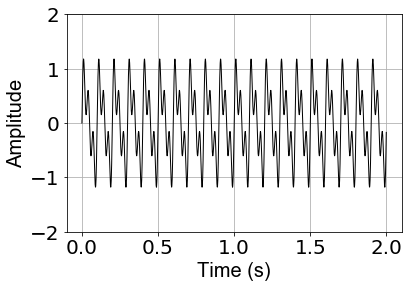

In [59]:
# plot the signal...
plt.plot(t, sw, 'k-', linewidth = 1)  
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(np.arange(0,tmax+.5,.5), color='k', size=20)
plt.yticks(((-2,-1,0,1,2)), color='k', size=20)
plt.grid(1)
plt.show()

### Then FFT...and plot - you should be able to guess what this will look like!

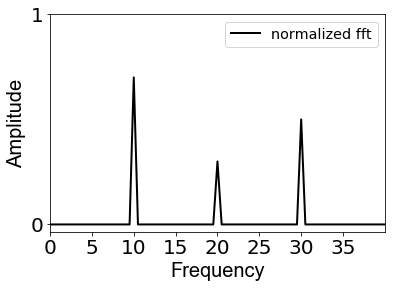

In [58]:
sp = np.fft.rfft(sw)                  # normalize by the number of data points
amp = (np.abs(sp) / len(sw)) *2
freq = np.fft.rfftfreq(sw.size, dt)   # Sample spacing is 2nd arg, inverse of the sampling rate. Defaults to 1!
plt.plot(freq, amp, 'k', linewidth=2) # plot amplitude (power = np.absolute(sp)**2)
plt.legend(['normalized fft'], loc='best', fontsize='x-large')  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(freq[0:80:10], color='k', size=20)
plt.yticks((0,1), color='k', size=20)
plt.xlim([0, 40])
plt.show()

## What limits the resolution of your measurements in the frequency domain? I.e. the spacing along the x-axis? 
* The freq. resolution is SR/N (sample rate / number of samples)
* so while intuition might suggest that increasing the sample rate will increase the frequency resolution, it does not! 
* We have FreqRes = SR/N = SR/(SR * T) =  1/T...so frequency resolution is dependent on the duration of data collection
* one intuition - suppose you only took 2 samples of a signal. Would you have very good resolution to represent that signal in the frequency domain? And would it matter whether you took the two samples at a fast or a slow rate? 

<div class="alert alert-info"> 
There is a fundemental tradeoff between time domain resolution and frequency domain resolution. The longer the time interval that you FFT, the higher your freq domain resolution will be. However, FFTing larger time bins means that you lose the ability to tell exactly WHEN something happened.
</div>

## However, there are some advantages of collecting data at a higher sample rate. 
* Increasing sample rate increases the **range** of frequencies that you can estimate (not the resolution, but the range)
* Increasing sample rate gives more stable estimates of the amplitude at each frequency in the presence of noise 

## To understand why this is, useful to think about the Nyquist limit...need to sample a signal at double the frequency that you want to examine

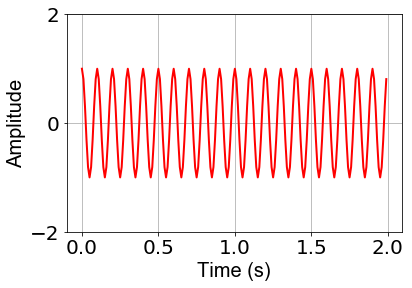

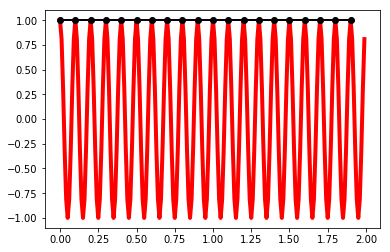

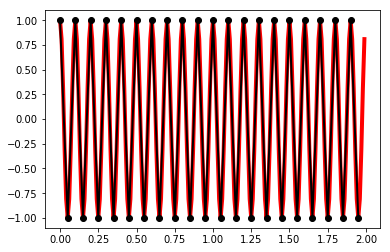

In [61]:
sr = 100                        # samp rate in Hz make it high and then we'll downsample to demonstrate.
f = 10                          # frequency of signal 
tmax = 2                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# make a cos wave - note: if you change to sin you get a line through 0
sw = np.cos(2*pi*f*t)

# plot the raw signal
plt.plot(t, sw, 'r-', linewidth = 2)    # specify x,y data...convert rad to deg for x-axis
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(np.arange(0,tmax+.5,.5), color='k', size=20)
plt.yticks((-2,0,2), color='k', size=20)
plt.grid(1)
plt.show()

# then plot samples at 10Hz (or 1 sample every 10 data points)
plt.plot(t, sw, 'r-', linewidth = 4)                # plot the original data
plt.plot(t[::10], sw[::10], 'ko-', linewidth = 2)    # plot every 10th point to mimic a sr of 10Hz
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(np.arange(0,tmax+.5,.5), color='k', size=20)
plt.yticks((-2,0,2), color='k', size=20)
plt.grid(1)
plt.show()

# then plot samples at 20Hz (or 1 sample every 5 data points)
plt.plot(t, sw, 'r-', linewidth = 4)                # plot the original data
plt.plot(t[::5], sw[::5], 'ko-', linewidth = 2)     # plot every 5th point to mimic a sr of 10Hz
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(np.arange(0,tmax+.5,.5), color='k', size=20)
plt.yticks((-2,0,2), color='k', size=20)
plt.grid(1)
plt.show()

## And based on what we saw above, see what actually happens when you sample the data at different frequencies and then do the FFT (and notice what happens to the range of frequencies estimated)

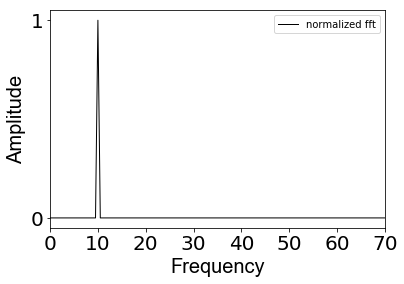

In [68]:
# watch what happens when we actually change the sampling rate of the data and then FFT
sr = 140                         # samp rate in Hz make it high and then we'll downsample to demonstrate.
f = 10                          # frequency of signal 
tmax = 2                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# make a cos wave
sw = np.cos(2*pi*f*t)

# FFT
sp = np.fft.rfft(sw)                  # fft
amp = (np.abs(sp) / len(sw)) * 2      # normalize by the number of data points
freq = np.fft.rfftfreq(sw.size, dt)   # Sample spacing is 2nd arg, inverse of the sampling rate. Defaults to 1!
plt.plot(freq, amp, 'k', linewidth=1)            # plot amplitude 
plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(freq[0::20], color='k', size=20)
plt.yticks((0,1), color='k', size=20)
plt.xlim([0, 70])
plt.show()

## Point number 2: here pick a fixed temporal interval and a fixed noise level and look at variability of amplitude estimates as a function of sampling rate. 
* Note again that frequency resolution does not change as a function of sample rate (just the max freq that can be estimated changes). 
* However, even though freq resolution doesn't change as samp rate gets higher you will be better able to reliably  recover the amplitude of an oscillation in the presence of noise. 
* You can think about this as a curve fitting problem - the more points you have to fit the more stable your fit is going to be...and if you're right at the minimum sample rate to estimate a frequency you're not going to get very stable estimates if your signal has noise. 

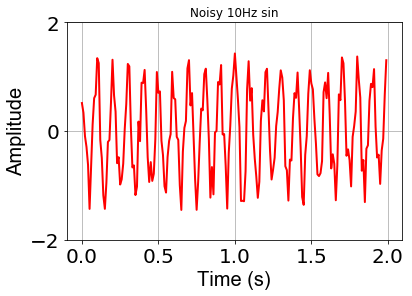

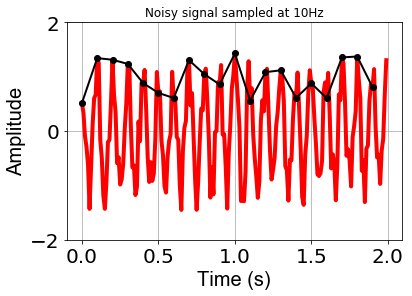

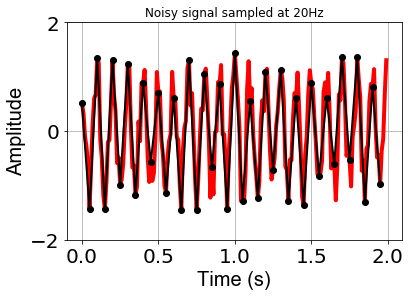

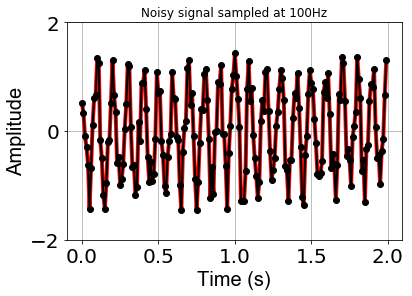

In [63]:
sr = 100                        # samp rate in Hz make it high and then we'll downsample to demonstrate.
f = 10                          # frequency of signal 
tmax = 2                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# amp of IID noise
noise_amp = 1

# make a cos wave
sw = np.cos(2*pi*f*t)

# add some noise
sw = sw + ((np.random.rand(len(sw))-.5) * noise_amp)


# plot the raw signal
plt.plot(t, sw, 'r-', linewidth = 2)    # specify x,y data...convert rad to deg for x-axis
plt.title('Noisy 10Hz sin')
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(np.arange(0,tmax+.5,.5), color='k', size=20)
plt.yticks((-2,0,2), color='k', size=20)
plt.grid(1)
plt.show()

# then plot samples at 10Hz (or 1 sample every 10 data points)
plt.plot(t, sw, 'r-', linewidth = 4)                # plot the original data
plt.plot(t[::10], sw[::10], 'ko-', linewidth = 2)    # plot every 10th point to mimic a sr of 10Hz
plt.title('Noisy signal sampled at 10Hz')
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(np.arange(0,tmax+.5,.5), color='k', size=20)
plt.yticks((-2,0,2), color='k', size=20)
plt.grid(1)
plt.show()

# then plot samples at 20Hz (or 1 sample every 5 data points)
plt.plot(t, sw, 'r-', linewidth = 4)                # plot the original data
plt.plot(t[::5], sw[::5], 'ko-', linewidth = 2)    # plot every 5th point to mimic a sr of 20Hz
plt.title('Noisy signal sampled at 20Hz')
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(np.arange(0,tmax+.5,.5), color='k', size=20)
plt.yticks((-2,0,2), color='k', size=20)
plt.grid(1)
plt.show()

# then plot samples at 100Hz (or 1 sample every data point)
plt.plot(t, sw, 'r-', linewidth = 4)                # plot the original data
plt.plot(t[::1], sw[::1], 'ko-', linewidth = 2)    # plot every point to mimic a sr of 100Hz
plt.title('Noisy signal sampled at 100Hz')
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(np.arange(0,tmax+.5,.5), color='k', size=20)
plt.yticks((-2,0,2), color='k', size=20)
plt.grid(1)
plt.show()

## now systematically vary the sample rate to see how reliable our power estimates are with a fixed level of noise. 

Frequency resolution at each samp rate:  [0.5 0.5 0.5 0.5 0.5 0.5 0.5]


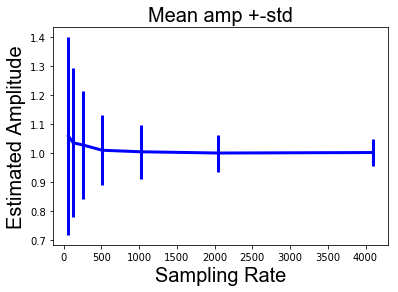

In [64]:
sr = np.array([64, 128, 256, 512, 1024, 2048, 4096])  # samp rate in Hz
f = 24                          # frequency of signal 
tmax = 2                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
noise_amp = 10                  # amplitude of additive IID noise (this is actually 2*amp of noise)
num_iterations = 500            # how many times to loop to eval impact of noise as a function of 

# little note on frequency resolution - function of number of data samples and sample rate
num_data_samps = sr * tmax      # just samp rate * how many seconds of data

# freq resolution...note that the ONLY thing that increases freq resolution is more time!
# for a fixed amount of time the increase in sr and the length of data scale proportionally. 
fstepSz = sr / num_data_samps   
print('Frequency resolution at each samp rate: ', fstepSz)

# allocate arrray to store amp at target frequency f
amp = np.zeros((num_iterations,len(sr)))

# loop over iterations to get an estimate of variaiblity of amp estimates at a given noise level. 
for j in range(num_iterations):
    
    # then loop over sample rates...
    for i in range(len(sr)):
        
        t = np.arange(0,tmax,dt[i])        # time axis

        # make a sin wave
        sw = np.sin(2*pi*f*t) 

        # add some noise. 
        sw = sw + (np.random.rand((len(sw))) - .5) * noise_amp

        # FFT, with * dt to normalize the amplitude for number of samples in timeseries  
        # sp = np.fft.rfft(sw) * dt[i]     
        sp = (np.abs(np.fft.rfft(sw)) / len(sw)) * 2

        # get your freq axis
        freq = np.fft.rfftfreq(sw.size, dt[i])        

        # find the nearest value to your target frequency (in this first example it should always be spot on)
        ind = np.argmin(np.abs(f-freq))

        amp[j,i] = sp[ind]

# plot...
mean_amp = np.mean(amp,0)
std_amp = np.std(amp,0)
plt.errorbar(sr, mean_amp, std_amp, color = 'b', linewidth = 3, ecolor = 'b', elinewidth = 3)
plt.title('Mean amp +-std', **fig_font)
plt.xlabel('Sampling Rate', **fig_font)
plt.ylabel('Estimated Amplitude', **fig_font)
plt.show()

# plt.violinplot(dataset=amp, positions=sr, widths=100)
# plt.show()

## Last point: Important to carefully epoch your data so that your frequency steps land EXACTLY on the frequency of interest
* To illustrate, change the duration of data collection (tmax) from 2s to something weird like 2.56s.
* Notice how the amp goes down with 2.56 even though you have more data! why? 
* Now try fixing the duration (tmax) at 2s but change the frequ (f) to something like 24.22...what happens now? 

Freq resolution:  0.4950447183949722


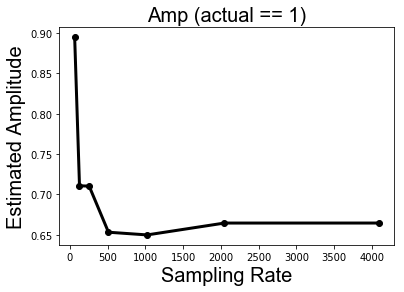

0.4950447183949722

In [44]:
sr = np.array([64, 128, 256, 512, 1024, 2048, 4096])  # samp rate in Hz
f = 24                          # frequency of signal 
tmax = 2.02                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
noise_amp = 0                   # amplitude of additive IID noise (this is actually 2*amp of noise)
num_iterations = 250            # how many times to loop to eval impact of noise as a function of 

# allocate arrray to store amp at target frequency f
amp = np.zeros(len(sr))

# loop over sample rates...
for i in range(len(sr)):
    t = np.arange(0,tmax,dt[i])        # time axis

    # make a sin wave
    sw = np.sin(2*pi*f*t) 
    
    # add some noise. 
    sw = sw + (np.random.rand((len(sw))) - .5) * noise_amp
    
    # FFT, with * dt to normalize the amplitude for number of samples in timeseries  
    # sp = np.fft.rfft(sw) * dt[i]     
    sp = (np.abs(np.fft.rfft(sw)) / len(sw)) * 2

    # get your freq axis
    freq = np.fft.rfftfreq(sw.size, dt[i])        

    # find the nearest value to your target frequency
    ind = np.argmin(np.abs(f-freq))

    amp[i] = sp[ind]

print('Freq resolution: ', freq[1]-freq[0])
plt.plot(sr, amp, 'ko-', linewidth = 3)
plt.title('Amp (actual == 1)', **fig_font)
plt.xlabel('Sampling Rate', **fig_font)
plt.ylabel('Estimated Amplitude', **fig_font)
plt.show()

freq[1]-freq[0]

## Another way to look at the same thing - take our mixture of 3 sin waves and change the sample duration a little to see what happens

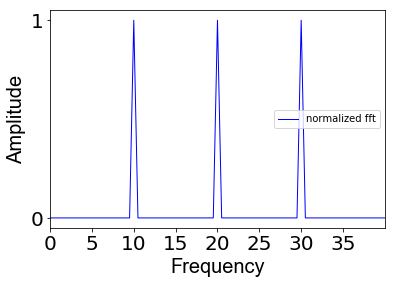

In [46]:
sr = 1024                       # samp rate in Hz
f = np.array([10,20,30])        # base frequencies in signal 
amp = np.array([1,1,1])
tmax = 2                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# make a more complex sin wave
sw = amp[0]*np.sin(2*pi*f[0]*t)+amp[1]*np.sin(2*pi*f[1]*t)+amp[2]*np.sin(2*pi*f[2]*t)

# plot the FFT
sp = np.fft.rfft(sw)                  # normalize by the number of data points
amp = (np.abs(sp) / len(sw)) *2
freq = np.fft.rfftfreq(sw.size, dt)   # Sample spacing is 2nd arg, inverse of the sampling rate. Defaults to 1!
plt.plot(freq, amp, 'b', linewidth=1) # plot amplitude (power = np.absolute(sp)**2)
plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(freq[0:80:10], color='k', size=20)
plt.yticks((0,1), color='k', size=20)
plt.xlim([0, 40])
plt.show()

## Summary
* FFT is a linear transform of the data and is just another way of representing the exact same information
* Because its a linear transform you can losslessly go from one representation to the other (FFT and inverse FFT)
* The frequency resolution (step size) is dependent on tmax, not on sample rate
* However, sample rate DOES determine the ranage of frequencies that you can characterize, and sample rate has to be at minimum twice as high as the frequency of intereset (Nyquist)
* That said, having a sample rate at double the frequency of interest is a minimum requirement, having a higher sampling rate is good, especially in high noise regimes
* Given that frequency resolution (step size) depends on data length, you can easily miss a frequency-of-interest if you don't carefully select the length of your data epoch. This is also true if you are driving the system and you are off a bit in the driving frequency 